In [1]:
import os
import healpy as hp
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from lenstools import ConvergenceMap
from astropy import units as u

In [2]:
from src.info_extractor import InfoExtractor
from src.patch_analyser import PatchAnalyser
from src.fullsky_analyser import FullSkyAnalyser
from analysis import KappaAnalyser
from src.patch_processor import PatchProcessor
from src.utils import load_config, filter_config, setup_logging

In [3]:
workdir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
config_file = workdir / "configs" / "config_default.yaml"
config = load_config(config_file)
setup_logging()
zs =2.0

In [4]:
patch_size = config["patch_size"]
nbin = config["nbin"]
bins = np.linspace(-4, 4, nbin+1, endpoint=True)
binwidth = bins[1] - bins[0]
nu = (bins[1:] + bins[:-1]) / 2

In [5]:
sample_patch_tiled_path = list((workdir / "data" / "patches"/ "tiled"/ f"zs{zs}").glob(f"*.npy"))[1]
sample_patch_bigbox_path = list((workdir / "data" / "patches"/ "bigbox"/ f"zs{zs}").glob(f"*.npy"))[1]

In [6]:
sample_patch_tiled = np.load(sample_patch_tiled_path)
sample_patch_bigbox = np.load(sample_patch_bigbox_path)

In [7]:
# exclude index 130, 132, 134
sample_patch_tiled = np.delete(sample_patch_tiled, [130, 132, 134], axis=0)
sample_patch_bigbox = np.delete(sample_patch_bigbox, [130, 132, 134], axis=0)

In [8]:
conv_map_tiled = ConvergenceMap(sample_patch_tiled[0], angle=patch_size * u.deg).smooth(2.0 * u.arcmin)
conv_map_bigbox = ConvergenceMap(sample_patch_bigbox[0], angle=patch_size * u.deg).smooth(2.0 * u.arcmin)

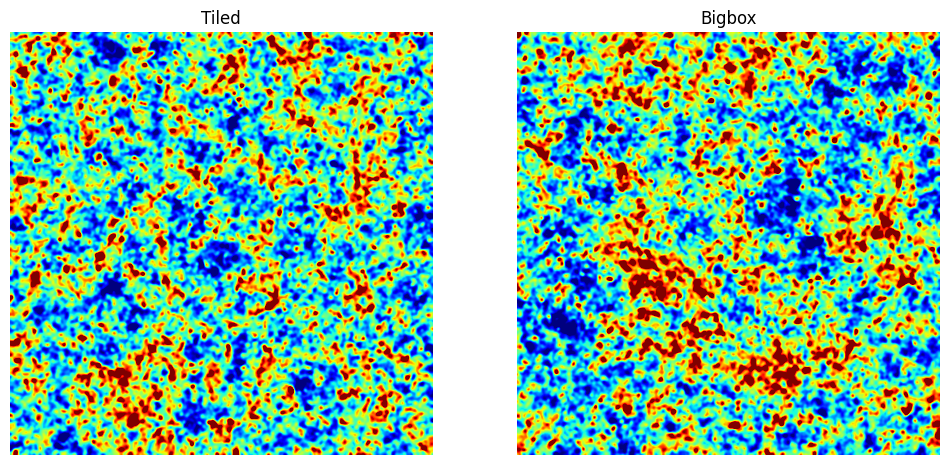

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(conv_map_tiled.data, cmap="jet", vmin=-0.032, vmax=0.032)
ax[0].set_title("Tiled")

ax[1].imshow(conv_map_bigbox.data, cmap="jet", vmin=-0.032, vmax=0.032)
ax[1].set_title("Bigbox")

for a in ax:
    a.axis("off")

plt.show()

In [10]:
from typing import Tuple
from scipy.special import erf

class FlatPatch:
    def __init__(self, data: np.ndarray):
        self.data = data
        self.mu = np.mean(data)
        self.size = data.size

        self.gradient_x, self.gradient_y = self.compute_gradient(data)
        self.hessian_xx, self.hessian_yy, self.hessian_xy = self.compute_hessian(data)

        self.sigma0 = np.std(data)
        self.sigma1 = np.sqrt(np.mean(self.gradient_x**2 + self.gradient_y**2))

    @staticmethod
    def compute_gradient(data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Computes the gradient of a 2D map.

        Parameters:
            data (np.ndarray): 2D input array.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Gradients along the x and y axes.
        """
        gradient_y, gradient_x = np.gradient(data)
        return gradient_x, gradient_y

    @staticmethod
    def compute_hessian(data: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Computes the Hessian matrix of a 2D map using finite differences.

        Parameters:
            data (np.ndarray): 2D input array.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: Hessian components.
        """
        gradient_y, gradient_x = np.gradient(data)
        hessian_xy, hessian_xx = np.gradient(gradient_x)
        hessian_yy, hessian_yx = np.gradient(gradient_y)
        return hessian_xx, hessian_yy, hessian_xy

    def Gaussian_MinkowskiFunctionals(self, nu: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        V0 = 0.5 * (1.0 - erf((nu - self.mu) / (np.sqrt(2) * self.sigma0)))
        V1 = (self.sigma1 / (8.0 * self.sigma0 * np.sqrt(2))) * np.exp(-((nu - self.mu) ** 2) / (2.0 * self.sigma0 ** 2))
        V2 = ((nu - self.mu) * (self.sigma1 ** 2) / (self.sigma0 ** 3) /
              (2.0 * (2.0 * np.pi) ** 1.5)) * np.exp(-((nu - self.mu) ** 2) / (2.0 * self.sigma0 ** 2))
        return V0, V1, V2

    def MinkowskiFunctionals(self, thresholds: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        denominator = self.gradient_x**2 + self.gradient_y**2
        s1 = np.sqrt(denominator)
        # Avoid division by zero
        denominator = np.where(denominator == 0, np.nan, denominator)
        frac = (2.0 * self.gradient_x * self.gradient_y * self.hessian_xy - 
                self.gradient_x**2 * self.hessian_yy - 
                self.gradient_y**2 * self.hessian_xx) / denominator
        frac = np.nan_to_num(frac)  # Replace NaNs with zero

        delta = np.diff(thresholds)
        nu = (thresholds[:-1] + thresholds[1:]) / 2.0

        # Initialize Minkowski functionals
        V0 = np.zeros(len(delta))
        V1 = np.zeros(len(delta))
        V2 = np.zeros(len(delta))

        for i in range(len(delta)):
            lower, upper = thresholds[i], thresholds[i + 1]
            mask = (self.data > lower) & (self.data < upper)

            V0[i] = np.sum(self.data > lower) / self.size
            V1[i] = np.sum(s1[mask] / 4.0) / (delta[i] * self.size)
            V2[i] = np.sum(frac[mask] / (2.0 * np.pi)) / (delta[i] * self.size)

        return nu, V0, V1, V2

In [39]:
mfs_tiled = []
for patch in sample_patch_tiled:
    conv_map = ConvergenceMap(patch, angle=patch_size * u.deg).smooth(2.0 * u.arcmin)
    sigma0 = np.std(conv_map.data)
    fp = FlatPatch(conv_map.data/sigma0)
    nu, V0, V1, V2 = fp.MinkowskiFunctionals(bins)
    mfs_tiled.append([V0, V1, V2])
mfs_tiled = np.array(mfs_tiled)

mfs_bigbox = []
for patch in sample_patch_bigbox:
    conv_map = ConvergenceMap(patch, angle=patch_size * u.deg).smooth(2.0 * u.arcmin)
    sigma0 = np.std(conv_map.data)
    fp = FlatPatch(conv_map.data/sigma0)
    nu, V0, V1, V2 = fp.MinkowskiFunctionals(bins)
    mfs_bigbox.append([V0, V1, V2])
mfs_bigbox = np.array(mfs_bigbox)

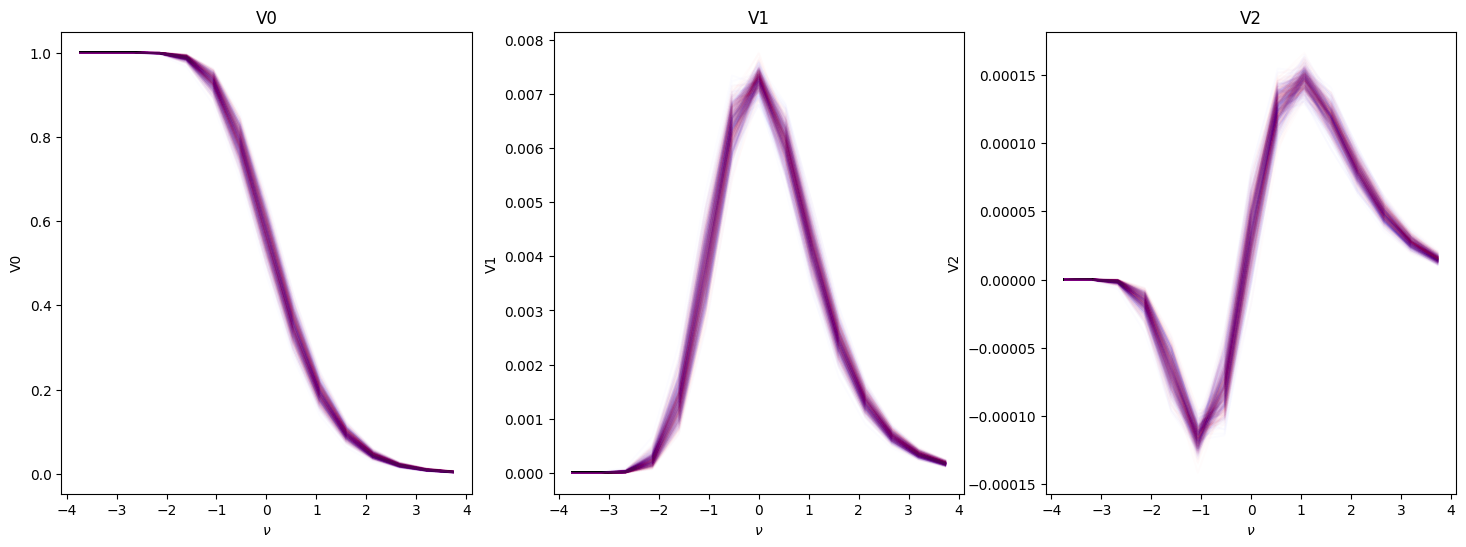

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    for j in range(mfs_tiled.shape[0]):
        ax[i].plot(nu, mfs_tiled[j, i], color="red", alpha=0.01)
        ax[i].plot(nu, mfs_bigbox[j, i], color="blue", alpha=0.01)
    ax[i].set_title(f"V{i}")
    ax[i].set_xlabel(r"$\nu$")
    ax[i].set_ylabel(f"V{i}")

In [40]:
def normalize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [ ]:
mfs_tiled_norm = [normalize(mfs_tiled[:, i]) for i in range(3)]
mfs_bigbox_norm = [normalize(mfs_bigbox[:, i]) for i in range(3)]

/var/tmp/pbs.305964.idark/ipykernel_254502/2256306337.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (x - np.mean(x, axis=0)) / np.std(x, axis=0)


In [55]:
bad_indices_tiled = [np.where(np.abs(mfs_tiled_norm[i]) > 4)[0] for i in range(3)]
bad_indices_bigbox = [np.where(np.abs(mfs_bigbox_norm[i]) > 4)[0] for i in range(3)]

In [ ]:
bad_indices_tiled 

In [58]:
#exclude bad indices
mfs_tiled_norm = [np.delete(mfs_tiled_norm[i], bad_indices_tiled[i], axis=0) for i in range(3)]
mfs_bigbox_norm = [np.delete(mfs_bigbox_norm[i], bad_indices_bigbox[i], axis=0) for i in range(3)]

# also exclude the same indices from the original data
mfs_tiled = [np.delete(mfs_tiled[:, i], bad_indices_tiled[i], axis=0) for i in range(3)]
mfs_bigbox = [np.delete(mfs_bigbox[:, i], bad_indices_bigbox[i], axis=0) for i in range(3)]

In [63]:
mfs_tiled_norm[0].shape

(258, 15)

IndexError: index 257 is out of bounds for axis 0 with size 257

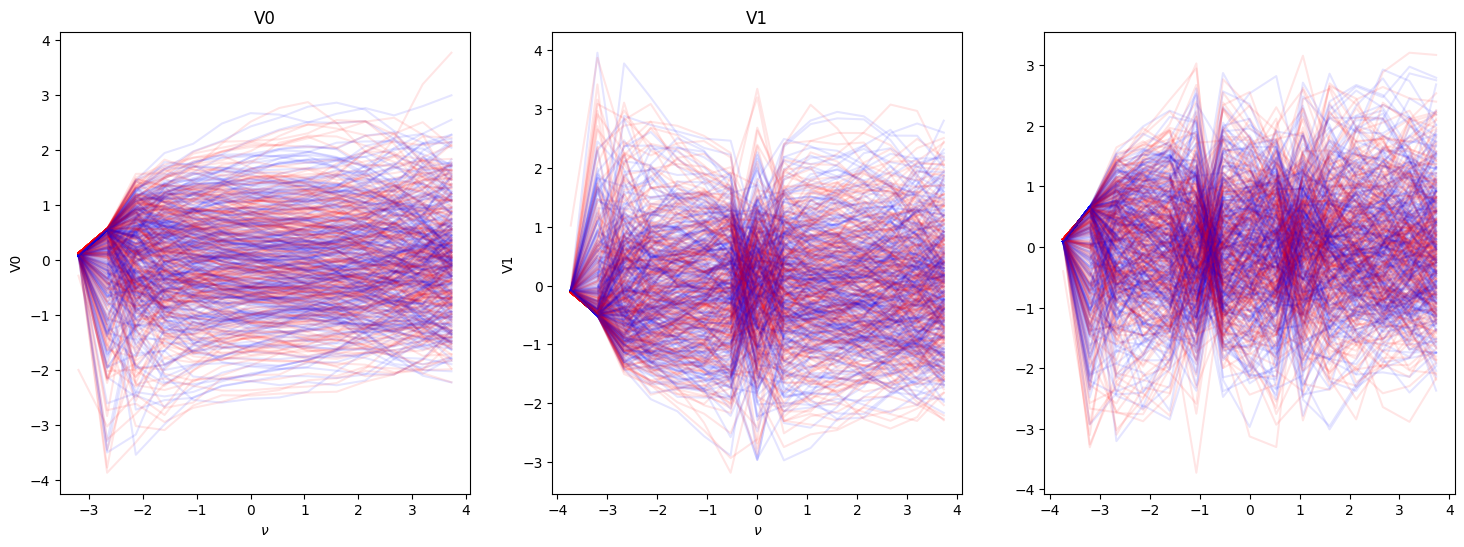

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    for j in range(mfs_tiled_norm[0].shape[0]):
        ax[i].plot(nu, mfs_tiled_norm[i][j], color="red", alpha=0.1)
        ax[i].plot(nu, mfs_bigbox_norm[i][j], color="blue", alpha=0.1)
    ax[i].set_title(f"V{i}")
    ax[i].set_xlabel(r"$\nu$")
    ax[i].set_ylabel(f"V{i}")

plt.legend([Line2D([0], [0], color="blue", lw=2), Line2D([0], [0], color="red", lw=2)], ["Tiled", "Bigbox"])

plt.xlabel(r"$\nu$")
plt.ylabel("normalized(mean=0, std=1)")
plt.show()

In [61]:
for i in range(1, 4):
    plt.hist(mfs_tiled_norm[:, -i], bins=20, alpha=0.5, label="Tiled:" + f"l = {nu[-i]:.2f}")
    plt.hist(mfs_bigbox_norm[:, -i], bins=20, alpha=0.5, label="Bigbox:" + f"l = {nu[-i]:.2f}")
plt.xlabel("normalized(mean=0, std=1)")
plt.ylabel("Count")
plt.legend()
plt.show()

TypeError: list indices must be integers or slices, not tuple

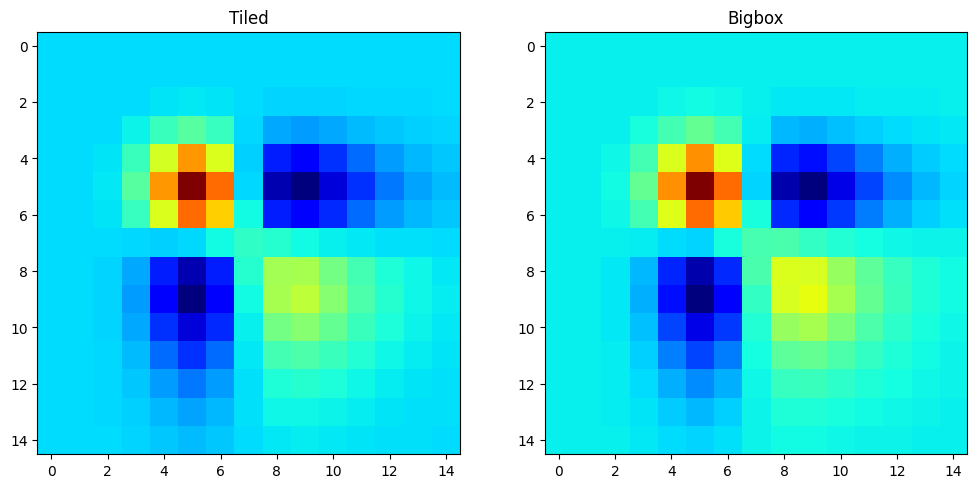

In [71]:
cov_tiled = np.cov(mfs_tiled[1].T)
cov_bigbox = np.cov(mfs_bigbox[1].T)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cov_tiled, cmap="jet")
ax[0].set_title("Tiled")
ax[1].imshow(cov_bigbox, cmap="jet")
ax[1].set_title("Bigbox")

plt.show()

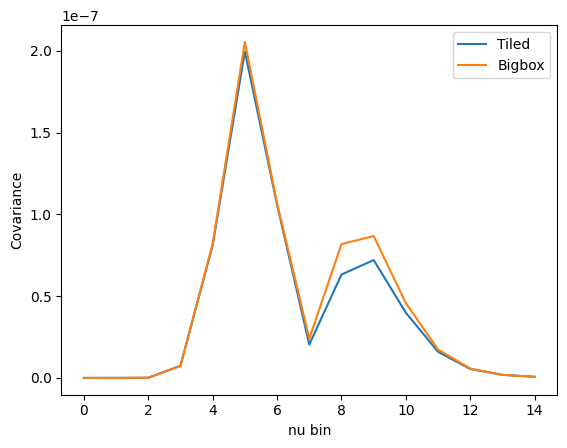

In [72]:
plt.plot(np.diag(cov_tiled), label="Tiled")
plt.plot(np.diag(cov_bigbox), label="Bigbox")
plt.legend()
plt.xlabel("nu bin")
plt.ylabel("Covariance")
plt.show()